#<center> Wells Fargo Quant AI Hackathon </center>
#<center> The Laal Street </center>
#<center> Shaastra 2022. </center>

This is the code submission for our team the Laal Street in the Wells Fargo Quant AI Hackathon in Shaastra 2022. The code has been made entirely in python (Jupyter notebooks in Google colab). We have used Keras and TensorFlow as a deep learning framework. We used pandas and numpy for handling the data, and matplotlib and seaborn for representing the data and getting insights from it. 

Importing the requires libraries

In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
df=pd.read_csv("training_data.csv")

We used these two heatmaps to be able to determine correlations in the data. 

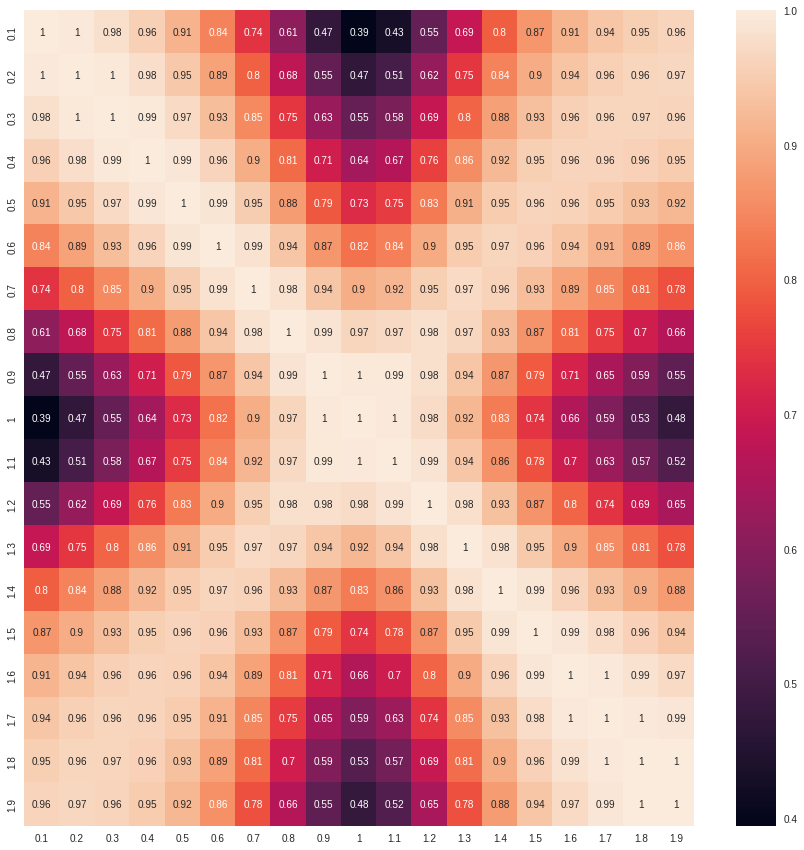

In [3]:
plt.style.use("seaborn")
# checking correlation using heatmap
correlation_mat = df.corr()
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
sns.heatmap(correlation_mat, annot = True)
plt.show()  #ploting the heatmap for correlation

##<center>Tenor-wise predictions</center>

We used the following function to do tenor-wise predictions for the data. It takes in a list with the data ordered, the number of epochs that are to be run in each iteration, an index for deceding the moneyness that the loop will run for, the number of elements it'll train on and predict in each iteration, and the model that is to be used. 

In [4]:
def dynamic_cell_state_moneyness(lst,epoch_n=1,moneyness_index=0,n_pred=20,n_train=300):
  temp=[]
  progress_index=0
  for i in range(0,17):
    m=lst[i]
    temporary_list_metric=[]
    print(progress_index)
    progress_index+=1
    testsys=0
    for j in range(moneyness_index+(718%n_pred)*19,13643-(n_train+n_pred-1)*19,19*n_pred):
      L=m.loc[j:j+((n_train-1)*19)].to_numpy().flatten()
      M=m.loc[j+n_train*19:j+(n_train+n_pred-1)*19].to_numpy().flatten()
      temporary_list_metric.append([L,M])
      testsys+=1
    temporary_list_metric=np.array(temporary_list_metric)
    temporary_list_metric=temporary_list_metric[0:testsys]
    model=tf.keras.Sequential([tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,return_sequences=True),input_shape=(n_train*3,1)),
                    tf.keras.layers.Dense(256),
                    tf.keras.layers.GRU(units=256),
                    tf.keras.layers.Dense(256),
                    tf.keras.layers.Dense(n_pred*3)])
    model.compile(loss='mean_squared_error',optimizer='Adam',metrics=['mean_absolute_error'])
    for jk in range(0,testsys):
      model.fit(np.array([temporary_list_metric[jk][0]]),np.array([temporary_list_metric[jk][1]]),epochs=epoch_n,verbose=0)
    temp1=lst[i].copy()
    temp1=temp1.to_numpy()
    temp1=pd.DataFrame(temp1)
    for jkl in range(718,850,n_pred):
      m=model.predict(np.array([temp1.loc[(jkl-n_train):(jkl-1),[0, 1, 2]].to_numpy().flatten()]))
      m=pd.DataFrame(m.reshape((n_pred,3)))
      temp1=pd.concat([temp1,m],ignore_index=True)
    temp.append(temp1)
  return temp

We used this loop to predict the values, and to generate the dataset. 

In [6]:
tenors_tuple=('2M','3M','6M','9M','1Y','2Y','3Y','4Y','5Y','6Y','7Y','8Y','9Y','10Y','15Y','20Y','25Y','30Y','40Y')
n=[]
progress_index_2=0
for st in tenors_tuple:
  k=df.loc[:,['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8',
      '0.9', '1', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8',
      '1.9']]
  data=k.loc[df['Tenor']==tenors_tuple]
  data.rename(columns = {'1':'1.0'}, inplace = True)
  lst=[]
  for i in range(1,18):
    p=str(i/10)
    q=str(int(i+1)/10)
    r=str(int(i+2)/10)
    temp=data.loc[:,[p,q,r]]
    lst.append(temp)
  b=dynamic_cell_state_moneyness(lst,moneyness_index=progress_index_2,epoch_n=1)
  progress_index_2+=1
  p=np.array(b)
  print(progress_index_2)
  k=pd.concat([pd.DataFrame(p[0]),pd.DataFrame(p[1]),pd.DataFrame(p[2]),pd.DataFrame(p[3]),pd.DataFrame(p[4]),pd.DataFrame(p[5]),pd.DataFrame(p[6]),pd.DataFrame(p[7]),pd.DataFrame(p[8]),pd.DataFrame(p[9]),pd.DataFrame(p[10]),pd.DataFrame(p[11]),pd.DataFrame(p[12]),pd.DataFrame(p[13]),pd.DataFrame(p[14]),pd.DataFrame(p[15]),pd.DataFrame(p[16])],axis=1,ignore_index=True)
  n.append(k)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0


ValueError: ignored

This code will convert the data into a csv file wich can then be downloaded. 

In [ ]:
master=[]
for j in range(857):
  for i in range(19):
    progress_list=[]
    progress_list.append(n[i][0][j])
    progress_list.append((n[i][1][j]+n[i][3][j])/2)
    for p in range(2,45,3):
      progress_list.append((n[i][p][j]+n[i][p+2][j]+n[i][p+4][j])/3)
    progress_list.append((n[i][47][j]+n[i][49][j])/2)
    progress_list.append(n[i][50][j])
    master.append(progress_list)
master=np.array(master)
master2=pd.DataFrame(master)
master2.to_csv('Preds.csv')

###<center>Moneyness-Based predictions</center>
We found that the correlation between different values of moneyness was more than the correlation that we ere getting for the different tenors. So we tried the same approach that we used for tenors and made predictions based on moneyness. However, the results that we got on these were worse than those that we got with tenors evn with heavier and more rhobust mmodels. So we decided to continue with a tenor-wise approach. 

In [ ]:
data=df.copy()
data=df.loc[:,['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8',
       '0.9', '1', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8',
       '1.9']]
data.rename(colutemporary_list_metric = {'1':'1.0'}, inplace = True)
data

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9
0,0.468214,0.419251,0.376260,0.338158,0.304372,0.274823,0.250066,0.231535,0.221404,0.220933,0.228418,0.240437,0.254316,0.268613,0.282659,0.296172,0.309045,0.321260,0.332831
1,0.458471,0.412710,0.372717,0.337489,0.306511,0.279714,0.257540,0.241007,0.231434,0.229423,0.233839,0.242411,0.253100,0.264611,0.276244,0.287647,0.298654,0.309196,0.319254
2,0.410305,0.374189,0.343045,0.316070,0.292842,0.273231,0.257346,0.245440,0.237726,0.234116,0.234078,0.236765,0.241295,0.246945,0.253200,0.259726,0.266312,0.272831,0.279207
3,0.385267,0.354580,0.328360,0.305878,0.286712,0.270643,0.257590,0.247529,0.240401,0.236030,0.234085,0.234121,0.235658,0.238264,0.241586,0.245360,0.249397,0.253564,0.257773
4,0.358986,0.333608,0.312126,0.293870,0.278408,0.265457,0.254819,0.246339,0.239855,0.235185,0.232109,0.230384,0.229760,0.230003,0.230908,0.232303,0.234052,0.236049,0.238213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13637,0.290467,0.274071,0.259819,0.247286,0.236167,0.226238,0.217329,0.209309,0.202077,0.195550,0.189663,0.184359,0.179593,0.175321,0.171508,0.168118,0.165119,0.162481,0.160172
13638,0.279726,0.263635,0.249695,0.237473,0.226660,0.217030,0.208411,0.200674,0.193716,0.187456,0.181826,0.176772,0.172247,0.168208,0.164617,0.161440,0.158642,0.156194,0.154063
13639,0.275693,0.259711,0.245916,0.233859,0.223221,0.213769,0.205330,0.197769,0.190981,0.184884,0.179409,0.174499,0.170106,0.166187,0.162703,0.159618,0.156900,0.154517,0.152440
13640,0.271637,0.256054,0.242648,0.230965,0.220685,0.211571,0.203450,0.196186,0.189673,0.183826,0.178577,0.173867,0.169647,0.165873,0.162507,0.159514,0.156861,0.154518,0.152458


In [ ]:
import math
master=[]
for i in range(0,17): 
  lst=[]
  for j in range(1,20):
    temp=[]
    k=str(format(j/10, '.1f'))
    for p in range(i,13640,19):
      temp.append(np.array([data[k][p],data[k][p+1],data[k][p+2]]))
    lst.append(temp)
  lst=np.array(lst)
  master.append((lst))
for i in range(17):
  master[i]=master[i].reshape(19*718,3)
  master[i]=pd.DataFrame(master[i])
mastermaster=[]
for i in range(0,17):
  singlemaster=[]
  for j in range(0,13642,718):
    singlemaster.append(master[i].loc[j:j+717])
  mastermaster.append(singlemaster)
for i in range(17):
  for j in range(19):
    k=mastermaster[i][j].to_numpy()
    mastermaster[i][j]=pd.DataFrame(k)

In [ ]:
model1=tf.keras.Sequential([tf.keras.layers.LSTM(512,input_shape=(300,1),return_sequences=True),
                        tf.keras.layers.Dense(128),
                        tf.keras.layers.Droprogress_index_2t(0.1),
                        tf.keras.layers.GRU(units=32),
                        tf.keras.layers.Droprogress_index_2t(0.1),
                        tf.keras.layers.Dense(32),
                        tf.keras.layers.Dense(30)])

In [ ]:
final=[]
progress_index_5=0
for i in range(17):
  semifinal=[]
  progress_index_6=0
  progress_index_5+=1
  print(progress_index_5)
  for j in range(19):
    progress_index_6+=1
    print(progress_index_6)
    sub_data=mastermaster[i][j].copy()
    model=model1
    model.compile(loss='mean_squared_error',optimizer='Adam',metrics=['mean_absolute_error'])
    sub_data=sub_data.loc[:709]
    for k in range(0,600,10):
      sub_sub_data=tf.convert_to_tensor(np.asarray([sub_data.loc[k:k+99].to_numpy().flatten()]).astype(np.float32))
      sub_sub_train=tf.convert_to_tensor(np.asarray([sub_data.loc[k+100:k+109].to_numpy().flatten()]).astype(np.float32))
      model.fit(sub_sub_data,sub_sub_train,verbose=0)
    temp1=sub_data.copy()
    for p in range(710,820,10):
      m=model.predict(np.array([temp1.loc[p-100:p-1].to_numpy().flatten()]))
      m=pd.DataFrame(m[0].reshape((10,3)))
      temp1=pd.concat([temp1,m],ignore_index=True)
    semifinal.append(temp1)
  final.append(semifinal)
final
final1=final

1
1


KeyboardInterrupt: ignored

In [ ]:
import math
dummy=pd.DataFrame()
#2nd jiro for the moneyness
for j in range(19):
  k=[]
  for i in range(0,820):
    k.append(final1[0][j][0][i])
    k.append((final1[0][j][1][i]+final1[1][j][0][i])/2)
    k.append((final1[0][j][2][i]+final1[1][j][1][i]+final1[2][j][0][i])/3)
    k.append((final1[1][j][2][i]+final1[2][j][1][i]+final1[3][j][0][i])/3)
    k.append((final1[2][j][2][i]+final1[3][j][1][i]+final1[4][j][0][i])/3)
    k.append((final1[3][j][2][i]+final1[4][j][1][i]+final1[5][j][0][i])/3)
    k.append((final1[4][j][2][i]+final1[5][j][1][i]+final1[6][j][0][i])/3)
    k.append((final1[5][j][2][i]+final1[6][j][1][i]+final1[7][j][0][i])/3)
    k.append((final1[6][j][2][i]+final1[7][j][1][i]+final1[8][j][0][i])/3)
    k.append((final1[7][j][2][i]+final1[8][j][1][i]+final1[9][j][0][i])/3)
    k.append((final1[8][j][2][i]+final1[9][j][1][i]+final1[10][j][0][i])/3)
    k.append((final1[9][j][2][i]+final1[10][j][1][i]+final1[11][j][0][i])/3)
    k.append((final1[10][j][2][i]+final1[11][j][1][i]+final1[12][j][0][i])/3)
    k.append((final1[11][j][2][i]+final1[12][j][1][i]+final1[13][j][0][i])/3)
    k.append((final1[12][j][2][i]+final1[13][j][1][i]+final1[14][j][0][i])/3)
    k.append((final1[13][j][2][i]+final1[14][j][1][i]+final1[15][j][0][i])/3)
    k.append((final1[14][j][2][i]+final1[15][j][1][i]+final1[16][j][0][i])/3)
    k.append((final1[15][j][2][i]+final1[16][j][1][i])/2)
    k.append((final1[16][j][2][i]))
  index=str(format(((j+1)/10),'.1f'))
  dummy[index]=k
dummy.to_csv('Final.csv')